In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

In [3]:
#import saas file:
data_path = "data.sas7bdat"
df = pd.read_sas(data_path, format='sas7bdat', encoding='utf-8')

## Data Exploration and cleaning 

In [4]:
df.head()

,randhosp_id,randpat_id,pretrialexp,country,trialphase,phase,itt_treat,age,gender,deathcode,...,censor18,surv18,plan18,UKextra,disab_unknown6,vital_and_disabunknown6,disab_unknown18,vital_and_disabunknown18,treatment,haltcode
0,090,00001,2.0,UK,Open,2.0,0.0,81.0,1.0,E4,...,0.0,158.0,1.0,2.0,0.0,0.0,0.0,0.0,rt-PA,NaN
1,012,00002,1.0,SWEDEN,Open,2.0,1.0,92.0,1.0,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,Placebo,NaN
2,043,00003,1.0,POLAND,Open,2.0,1.0,75.0,1.0,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,Placebo,NaN
3,077,00004,2.0,UK,Open,2.0,0.0,60.0,1.0,NaN,...,1.0,548.0,1.0,2.0,0.0,0.0,0.0,0.0,rt-PA,I63
4,043,00005,1.0,POLAND,Open,2.0,0.0,88.0,1.0,NaN,...,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN,rt-PA,NaN


In [5]:
df.describe()

,pretrialexp,phase,itt_treat,age,gender,deathdate_unknown,randyear,randmonth,randhour,randmin,...,surv6,censor6,censor18,surv18,plan18,UKextra,disab_unknown6,vital_and_disabunknown6,disab_unknown18,vital_and_disabunknown18
count,3035.000000,3035.000000,3035.000000,3035.000000,3035.000000,1304.000000,3035.000000,3035.000000,3035.000000,3035.000000,...,3034.000000,3034.000000,2797.000000,2797.000000,3035.000000,3035.000000,3035.000000,3035.000000,2348.000000,2348.000000
mean,1.623064,1.909061,0.500824,77.310373,1.482702,1.991564,2008.091598,6.501153,13.966063,28.422735,...,143.997363,0.731707,0.637826,363.558455,1.226359,1.852059,0.028007,0.003624,0.024702,0.021721
std,0.484698,0.287570,0.500082,12.192014,0.499783,0.091492,2.414834,3.517671,4.753776,17.320742,...,68.309414,0.443144,0.480715,226.979553,0.418543,0.355100,0.165019,0.060104,0.155248,0.145801
min,1.000000,1.000000,0.000000,31.935000,1.000000,1.000000,2000.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,72.000000,1.000000,2.000000,2007.000000,3.000000,11.000000,15.000000,...,130.500000,0.000000,0.000000,129.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,1.000000,81.000000,1.000000,2.000000,2009.000000,6.000000,14.000000,30.000000,...,183.000000,1.000000,1.000000,548.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,86.000000,2.000000,2.000000,2010.000000,10.000000,17.000000,45.000000,...,183.000000,1.000000,1.000000,548.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2.000000,1.000000,97.846000,2.000000,2.000000,2011.000000,12.000000,23.000000,59.000000,...,183.000000,1.000000,1.000000,548.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
print("Number of rows:", df.shape[0])
print("Number of features:", df.shape[1])

Number of rows: 3035
Number of features: 266


In [7]:
cols_many_missing = df.columns[df.isnull().mean() > 0.5]

print("Columns with more than 50% missing values:", len(cols_many_missing.tolist()))
print("\n")
for col in df.columns:
    if col in cols_many_missing:
        print(f"{col}: {df[col].isnull().sum()} missing values")

Columns with more than 50% missing values: 40


deathcode: 1774 missing values
deathdate_unknown: 1731 missing values
randvioltype: 2993 missing values
haem_type7: 3033 missing values
nonstroke_type7: 2988 missing values
final_status: 2214 missing values
eighteenmonthform: 1606 missing values
eighteencompleted_by: 1608 missing values
euroqol18: 1722 missing values
yrfu_code: 2486 missing values
waiver_code: 2992 missing values
extracranial_bleed_site: 3012 missing values
other_effect_code: 2887 missing values
nostartcode: 2993 missing values
event_days: 2717 missing values
hypodeg: 1818 missing values
hypodegsite: 1818 missing values
mca: 1818 missing values
affmca: 1906 missing values
aspcau: 1906 missing values
asplen: 1906 missing values
aspins: 1906 missing values
aspint: 1906 missing values
aspm1: 1906 missing values
aspm2: 1906 missing values
aspm3: 1906 missing values
aspm4: 1906 missing values
aspm5: 1906 missing values
aspm6: 1906 missing values
oial: 1818 missing values
aca: 

## Define action, context, and reward:

### Action

In [10]:
action_cols = ['treatment']
actions = df[action_cols]

#check na
print("Number of missing values in action 'treatment':", actions.isnull().sum().item())

Number of missing values in action 'treatment': 0


### Reward

In [35]:
# columns relating to death
reward_cols = ['ohs18']
rewards = df[reward_cols]

#check na
print("Number of missing values in reward:", rewards.isnull().sum().item())

Number of missing values in reward: 525


In [36]:
# check for missing values in 'ohs6', surv18
print("Number of missing values in 'ohs6':", df['ohs6'].isnull().sum().item())

Number of missing values in 'ohs6': 0


Check if the 533 missing values of OHS 18 are from deaths:

In [45]:
for i in range(len(rewards)):
    #check if reward is nan
    if pd.isna(rewards.iloc[i, 0]):
        rewards.iloc[i, 0] = df['ohs6'].iloc[i, 0] #impute with ohs6 value        

In [52]:
rewards

,ohs18
0,6.0
1,2.0
2,0.0
3,1.0
4,3.0
...,...
3030,5.0
3031,6.0
3032,2.0
3033,6.0


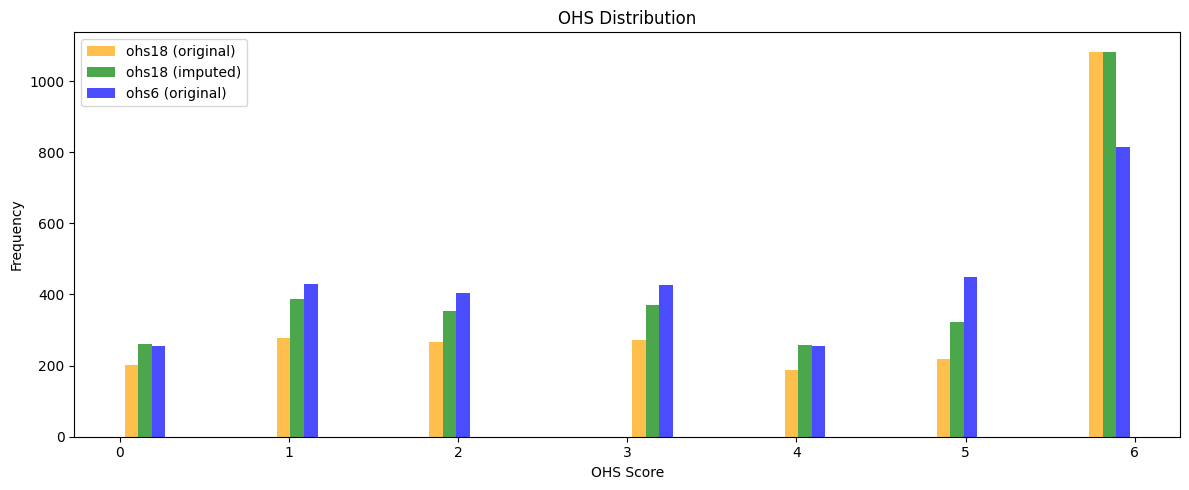

In [53]:
plt.figure(figsize=(12, 5))

plt.hist([df['ohs18'], rewards['ohs18'], df['ohs6']], bins=20, alpha=0.7, label=['ohs18 (original)', 'ohs18 (imputed)', 'ohs6 (original)'], color=['orange', 'green', 'blue'])
plt.title('OHS Distribution')
plt.xlabel('OHS Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


### Context:

In [58]:
initial_info_columns = [
  "randhosp_id",
  "randpat_id",
  "pretrialexp",
  "country",
  "trialphase",
  "phase",
  "itt_treat",
  "age",
  "gender",
  "randyear",
  "randmonth",
  "randhour",
  "randmin",
  "randdelay"
]

rand_columns = [
  "livealone_rand",
  "indepinadl_rand",
  "infarct",
  "antiplat_rand",
  "atrialfib_rand",
  "sbprand",
  "dbprand",
  "weight",
  "glucose",
  "gcs_eye_rand",
  "gcs_motor_rand",
  "gcs_verbal_rand",
  "gcs_score_rand",
  "nihss",
  "liftarms_rand",
  "ablewalk_rand",
  "weakface_rand",
  "weakarm_rand",
  "weakleg_rand",
  "dysphasia_rand",
  "hemianopia_rand",
  "visuospat_rand",
  "brainstemsigns_rand",
  "otherdeficit_rand",
  "stroketype",
  "pred_nihss",
  "konprob",
  # "randvioltype"
]

context_columns = initial_info_columns + rand_columns

In [66]:
context = df[context_columns]

#check na in context
missing_context = context.isnull().sum()
missing_context_cols = missing_context[missing_context > 0].index.tolist()

print("Number of missing values in context features:")
print(missing_context[missing_context > 0])

Number of missing values in context features:
dbprand     19
glucose    283
dtype: int64


In [ ]:
# impute missing context values
imputer = SimpleImputer(strategy='mean')
context_imputed = pd.DataFrame(imputer.fit_transform(context), columns=context.columns)
context_imputed.isnull().sum()

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'UK'